In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안

목표: 지역별 물류 최적화 방안
주제: 주문부터 배송 완료까지의 시간을 분석해서 물류 취약지역, 원인 확인 필요

배송지연 확률
배송지연이 많이 되는 구간
지역별 배송시간 차이
배송지연 건의 리뷰 점수 / 재시간에 배송된 리뷰점수 비교 (상관관계 분석)

In [3]:
from RFM import df_sellers, df_order_reviews, merge_coigp, df_product_category_name_translation

In [ ]:
# --- 1) 배송 완료 건만 필터 ---
df = merge_oics[merge_oics["order_status"] == "delivered"].copy()

# 배송완료 건 중 배송완료일이 없는 8건 삭제
# 배송완료인데 배송일자 없는 주문 제외
df = merge_oics[
    ~((merge_oics["order_status"] == "delivered") &
      (merge_oics["order_delivered_customer_date"].isna()))
].copy()

print("제외 전 주문수:", merge_oics["order_id"].nunique())
print("제외 후 주문수:", df["order_id"].nunique())


제외 전 주문수: 98328
제외 후 주문수: 98320


📌 단계별 평균 배송시간(일 단위)
purchase_to_approved     0.44
approved_to_carrier      2.85
carrier_to_customer      9.18
purchase_to_customer    12.47
dtype: float64

📌 ETA 대비 KPI
총 배송건수          112259.00
정시배송율               91.36
지연배송율                8.64
평균 지연일(지연건만)        10.50
dtype: float64

📌 지연 구간 분포 (%)
delay_days
정시/조기        93.39%
1-3일 지연       1.92%
3-7일 지연       1.82%
7-14일 지연      1.47%
14-30일 지연     1.06%
30일 초과        0.34%
Name: proportion, dtype: object


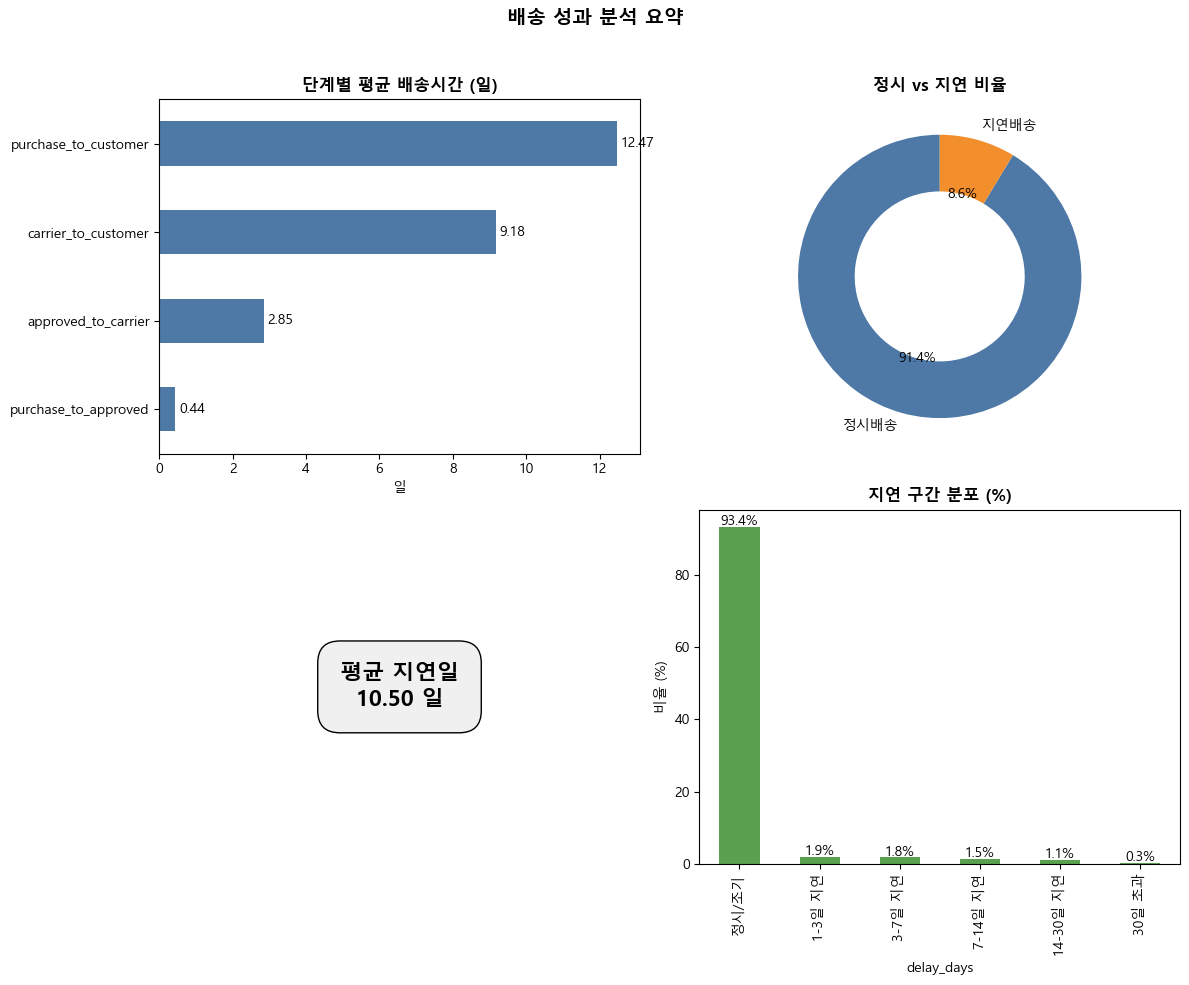

In [ ]:
# 전체 지연구간 확인
# 전체 구간 (구매 ~ 고객 수령) 계산
df["purchase_to_customer"] = (
    df["order_delivered_customer_date"] - df["order_purchase_timestamp"]
).dt.total_seconds() / 86400   # 일 단위

# 단계별 평균 다시 계산
step_cols = ["purchase_to_approved", "approved_to_carrier", "carrier_to_customer", "purchase_to_customer"]
step_mean = df[step_cols].mean().round(2)
print("📌 단계별 평균 배송시간(일 단위)")
print(step_mean)

# --- 3) ETA 대비 지연일 계산 ---
# ETA는 날짜 단위 비교 권장 → floor("d") 처리
df["delay_days"] = (
    df["order_delivered_customer_date"].dt.floor("d")
    - df["order_estimated_delivery_date"].dt.floor("d")
).dt.days

# 정시/지연 여부
df["on_time"] = df["delay_days"] <= 0

# KPI 요약
total = len(df)
on_time = df["on_time"].sum()
late = total - on_time
avg_delay = df.loc[df["delay_days"] > 0, "delay_days"].mean()

kpi = {
    "총 배송건수": total,
    "정시배송율": round(on_time / total * 100, 2),
    "지연배송율": round(late / total * 100, 2),
    "평균 지연일(지연건만)": round(avg_delay, 2)
}
print("\n📌 ETA 대비 KPI")
print(pd.Series(kpi))

# --- 4) 지연 구간 분포 ---
bins = [-np.inf, 0, 3, 7, 14, 30, np.inf]
labels = ["정시/조기", "1-3일 지연", "3-7일 지연", "7-14일 지연", "14-30일 지연", "30일 초과"]

delay_dist = pd.cut(df["delay_days"], bins=bins, labels=labels).value_counts(normalize=True).sort_index()
delay_dist = (delay_dist * 100).round(2)

print("\n📌 지연 구간 분포 (%)")
print(delay_dist.astype(str) + "%")

## 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- (1,1) 단계별 평균 배송시간 ---
step_mean.plot(kind="barh", color="#4e79a7", ax=axes[0,0])
axes[0,0].set_title("단계별 평균 배송시간 (일)", fontsize=12, fontweight="bold")
axes[0,0].set_xlabel("일")
for i, v in enumerate(step_mean):
    axes[0,0].text(v + 0.1, i, f"{v:.2f}", va="center")

# --- (1,2) 정시 vs 지연 비율 (도넛 차트) ---
labels = ["정시배송", "지연배송"]
sizes = [kpi["정시배송율"], kpi["지연배송율"]]
colors = ["#4e79a7", "#f28e2b"]
wedges, texts, autotexts = axes[0,1].pie(
    sizes, labels=labels, autopct="%.1f%%", startangle=90,
    colors=colors, wedgeprops=dict(width=0.4)
)
axes[0,1].set_title("정시 vs 지연 비율", fontsize=12, fontweight="bold")

# --- (2,1) 평균 지연일 (KPI 카드 스타일) ---
axes[1,0].axis("off")  # 축 숨기기
axes[1,0].text(
    0.5, 0.5,
    f"평균 지연일\n{avg_delay:.2f} 일",
    ha="center", va="center", fontsize=16, fontweight="bold",
    bbox=dict(facecolor="#f0f0f0", edgecolor="black", boxstyle="round,pad=1")
)

# --- (2,2) 지연 구간 분포 (막대그래프) ---
delay_dist.plot(kind="bar", color="#59a14f", ax=axes[1,1])
axes[1,1].set_title("지연 구간 분포 (%)", fontsize=12, fontweight="bold")
axes[1,1].set_ylabel("비율 (%)")
for i, v in enumerate(delay_dist):
    axes[1,1].text(i, v + 0.5, f"{v:.1f}%", ha="center")

plt.suptitle("배송 성과 분석 요약", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()



📌 주(state)별 배송 성과
                  주문수  평균_전체배송시간  정시배송율  평균_지연일
customer_state                                 
AC                 92      20.72   96.0   18.67
AL                439      24.41   76.0    9.87
AM                165      26.39   96.0   24.40
AP                 81      28.29   95.0   96.33
BA               3781      19.23   85.0   11.81
CE               1469      21.00   83.0   14.70
DF               2400      12.96   92.0    7.89
ES               2243      15.67   88.0   10.80
GO               2321      15.40   91.0   12.20
MA                823      21.65   80.0    9.87
MG              13070      11.98   94.0    8.41
MS                815      15.56   90.0    7.97
MT               1051      17.98   92.0   10.27
PA               1079      23.75   87.0   12.52
PB                598      20.58   87.0    9.95
PE               1798      18.27   88.0   11.73
PI                540      19.41   83.0   12.76
PR               5718      11.95   95.0    8.13
RJ              14492 

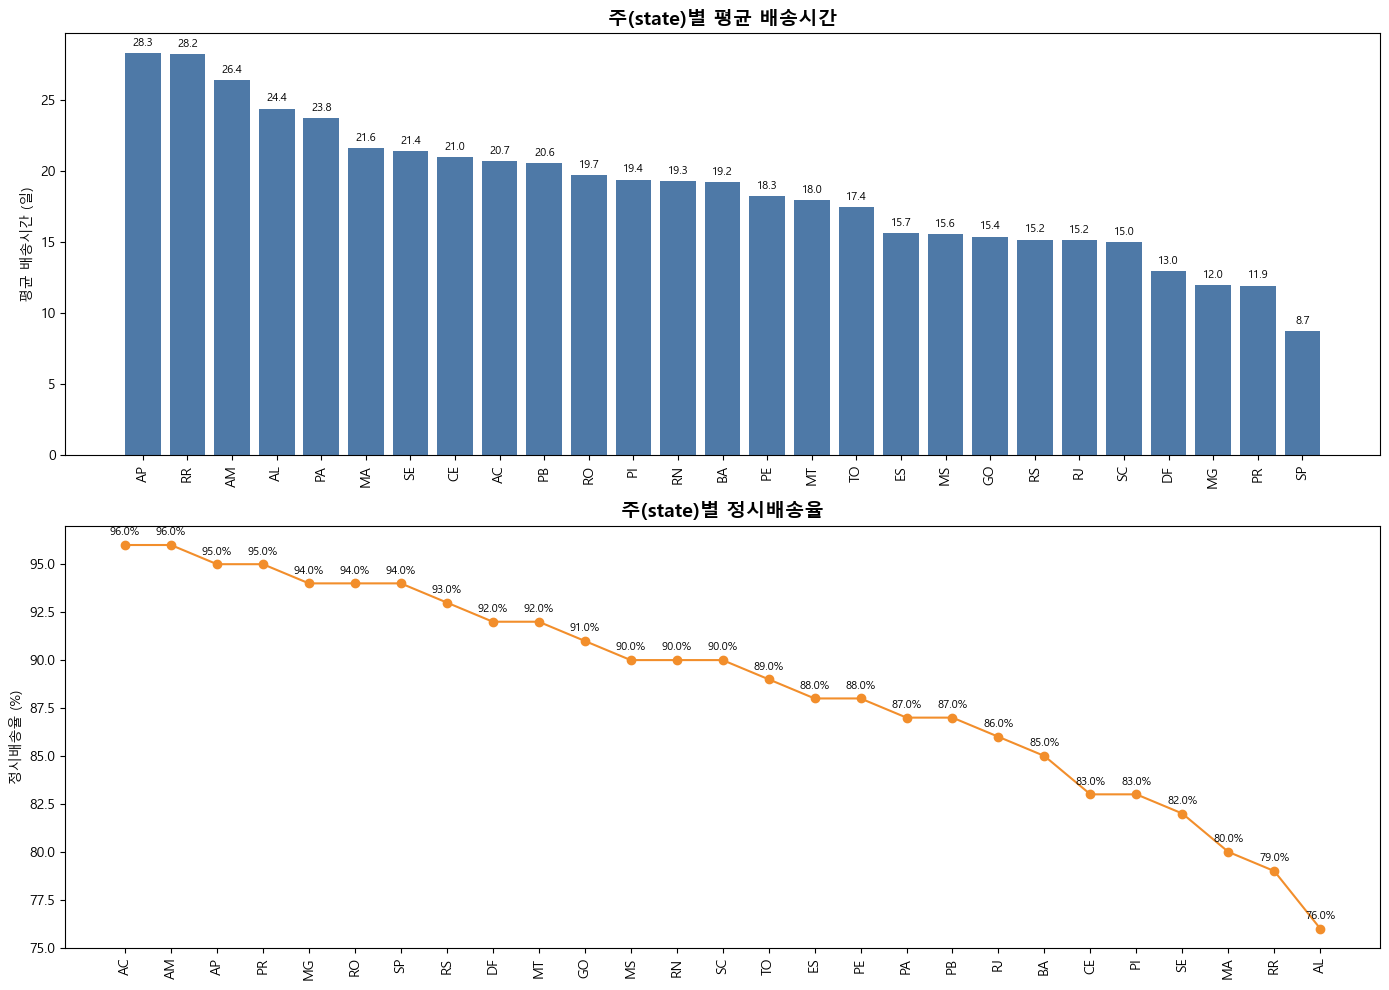

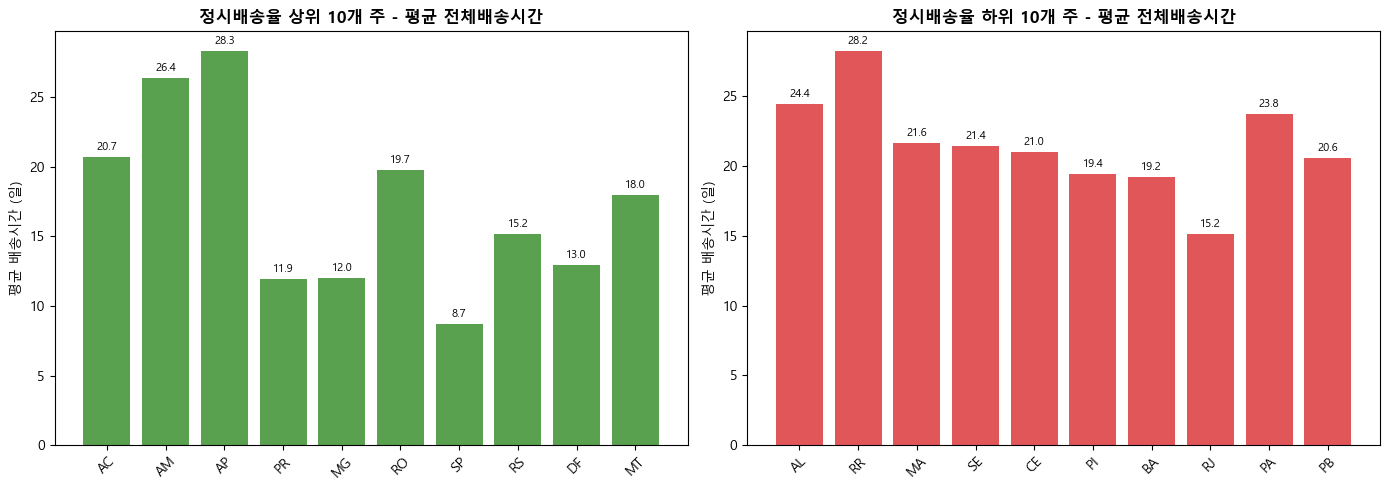

In [ ]:
# 지역별 배송 성과
# 전체 구간 (구매 ~ 고객 수령) 계산
df["purchase_to_customer"] = (
    df["order_delivered_customer_date"] - df["order_purchase_timestamp"]
).dt.total_seconds() / 86400   # 일 단위

# ETA 대비 지연일 계산
df["delay_days"] = (
    df["order_delivered_customer_date"].dt.floor("d")
    - df["order_estimated_delivery_date"].dt.floor("d")
).dt.days

# 정시배송 여부
df["on_time"] = df["delay_days"] <= 0

# 주(state)별 집계
state_perf = (
    df.groupby("customer_state")
      .agg(
          주문수=("order_id", "count"),
          평균_전체배송시간=("purchase_to_customer", "mean"),
          정시배송율=("on_time", "mean"),
          평균_지연일=("delay_days", lambda x: x[x > 0].mean())
      )
      .round(2)
)

# 정시배송율을 %로 변환
state_perf["정시배송율"] = (state_perf["정시배송율"] * 100).round(2)
print("📌 주(state)별 배송 성과")
print(state_perf)

# top 5주, 하위 5주
# 상위 5개 주 (정시배송율 내림차순, 평균 전체배송시간 오름차순)
top5_states = state_perf.sort_values(
    by=["정시배송율", "평균_전체배송시간"],
    ascending=[False, True]
).head(5)

# 하위 5개 주 (정시배송율 오름차순, 평균 전체배송시간 내림차순)
bottom5_states = state_perf.sort_values(
    by=["정시배송율", "평균_전체배송시간"],
    ascending=[True, False]
).head(5)

print("📌 배송 성과 상위 5개 주")
print(top5_states)

print("\n📌 배송 성과 하위 5개 주")
print(bottom5_states)

## 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# (1행) 주별 평균 배송시간\
state_perf_sorted = state_perf.sort_values("평균_전체배송시간", ascending=False)
axes[0].bar(state_perf_sorted.index, state_perf_sorted["평균_전체배송시간"], color="#4e79a7")
axes[0].set_title("주(state)별 평균 배송시간", fontsize=14, fontweight="bold")
axes[0].set_ylabel("평균 배송시간 (일)")
axes[0].tick_params(axis='x', rotation=90)

for i, v in enumerate(state_perf_sorted["평균_전체배송시간"]):
    axes[0].text(i, v + 0.5, f"{v:.1f}", ha="center", fontsize=8)

# (2행) 주별 정시배송율
state_perf_sorted2 = state_perf.sort_values("정시배송율", ascending=False)
axes[1].plot(state_perf_sorted2.index, state_perf_sorted2["정시배송율"], marker="o", color="#f28e2b")
axes[1].set_title("주(state)별 정시배송율", fontsize=14, fontweight="bold")
axes[1].set_ylabel("정시배송율 (%)")
axes[1].tick_params(axis='x', rotation=90)

for i, v in enumerate(state_perf_sorted2["정시배송율"]):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha="center", fontsize=8)

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# 상위 10개, 하위 10개 주 선택
top10_states = state_perf.sort_values("정시배송율", ascending=False).head(10)
bottom10_states = state_perf.sort_values("정시배송율", ascending=True).head(10)

# 1행 2열 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (왼쪽) 상위 10개 주
axes[0].bar(top10_states.index, top10_states["평균_전체배송시간"], color="#59a14f")
axes[0].set_title("정시배송율 상위 10개 주 - 평균 전체배송시간", fontsize=12, fontweight="bold")
axes[0].set_ylabel("평균 배송시간 (일)")
axes[0].tick_params(axis='x', rotation=45)

for i, v in enumerate(top10_states["평균_전체배송시간"]):
    axes[0].text(i, v + 0.5, f"{v:.1f}", ha="center", fontsize=8)

# (오른쪽) 하위 10개 주
axes[1].bar(bottom10_states.index, bottom10_states["평균_전체배송시간"], color="#e15759")
axes[1].set_title("정시배송율 하위 10개 주 - 평균 전체배송시간", fontsize=12, fontweight="bold")
axes[1].set_ylabel("평균 배송시간 (일)")
axes[1].tick_params(axis='x', rotation=45)

for i, v in enumerate(bottom10_states["평균_전체배송시간"]):
    axes[1].text(i, v + 0.5, f"{v:.1f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()



# 2. 고객 리뷰와 배송 지연 영향 분석

지역별 배송 성과 (평균 배송일수, 정시율, 지연율)
배송 지연 → 리뷰 점수 하락 여부

# merge

In [ ]:
# (merge_oics = df) + df_order_reviews => merge_oicsr
# product_category_name

review_agg = (
    df_order_reviews
    .groupby("order_id")
    .agg(
        review_score_mean=("review_score", "mean"),     # 평균 리뷰 점수
        review_count=("review_id", "count"),            # 리뷰 개수
        has_text=("has_text", "max"),                   # 텍스트 리뷰 여부 (1건이라도 있으면 1)
        first_review_date=("review_creation_date", "min"),
        last_review_date=("review_creation_date", "max"),
        sample_review_title=("review_comment_title", "first"),
        sample_review_message=("review_comment_message", "first")
    )
    .reset_index()
)

# =========================================
# 3) 배송 데이터와 합병
# =========================================
merge_oicsr = merge_oics.merge(
    review_agg,
    on="order_id",
    how="left"    # 리뷰 없는 주문도 유지
)

# 4) 확인
print("merge_oics shape:", merge_oics.shape)
print("review_agg shape:", review_agg.shape)
print("merge_oicsr shape:", merge_oicsr.shape)

merge_oics shape: (112267, 29)
review_agg shape: (98673, 8)
merge_oicsr shape: (112267, 36)


건수(주문 기준):
on_time
True     89123
False     6372
Name: count, dtype: int64

평균 리뷰 점수 (주문 단위):
on_time
지연    2.270951
정시    4.289927
Name: review_score_mean, dtype: float64

표준편차:
on_time
지연    1.570454
정시    1.148433
Name: review_score_mean, dtype: float64

정시 - 지연 평균 점수 차이: 2.019


C:\Users\mumu1\AppData\Local\Temp\ipykernel_17252\2081197667.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(plot_data, labels=labels, showmeans=True)


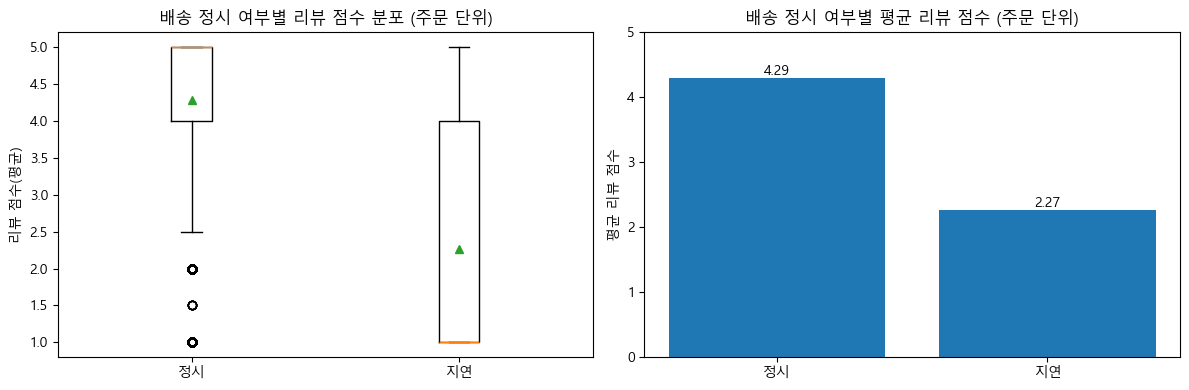

In [ ]:
# 지연 여부에 따른 리뷰 점수 비교
# ===== 0) 주문 단위로 정리 (중복 제거) =====
# review_score_mean이 주문 단위 지표이므로 order_id당 1행으로
order_cols = [
    "order_id",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_score_mean",
    "review_count"
]
dfm = (
    merge_oicsr[order_cols]
    .drop_duplicates(subset=["order_id"])
    .copy()
)

# ===== 1) 지연일수/정시 여부 생성 =====
# delay_days = (실제 고객 수령일 - 예상수령일) [일]
dfm["delay_days"] = (
    dfm["order_delivered_customer_date"].dt.floor("D")
    - dfm["order_estimated_delivery_date"].dt.floor("D")
).dt.days

# 정시 여부: 0일 이하(예정보다 같거나 빠름) = True
dfm["on_time"] = dfm["delay_days"] <= 0

# 분석에 필요한 값만 남기기: 리뷰점수/배송일자 결측 제거
dfm = dfm.dropna(subset=["review_score_mean", "order_delivered_customer_date", "order_estimated_delivery_date"])

print("건수(주문 기준):")
print(dfm["on_time"].value_counts(dropna=False))

# ===== 2) 단순 평균 비교 =====
avg_by_on_time = dfm.groupby("on_time", dropna=False)["review_score_mean"].mean()
std_by_on_time = dfm.groupby("on_time", dropna=False)["review_score_mean"].std()

print("\n평균 리뷰 점수 (주문 단위):")
print(avg_by_on_time.rename({True:"정시", False:"지연"}))

print("\n표준편차:")
print(std_by_on_time.rename({True:"정시", False:"지연"}))

diff = avg_by_on_time.get(True, np.nan) - avg_by_on_time.get(False, np.nan)
print("\n정시 - 지연 평균 점수 차이:", np.round(diff, 4))

## 시각화
# ===== 데이터 준비 =====
data_on  = dfm.loc[dfm["on_time"]==True,  "review_score_mean"].values
data_off = dfm.loc[dfm["on_time"]==False, "review_score_mean"].values

labels = ["정시", "지연"]
plot_data = [data_on, data_off]
# 비어있는 그룹 제외
labels = [lab for lab, arr in zip(labels, plot_data) if len(arr) > 0]
plot_data = [arr for arr in plot_data if len(arr) > 0]

x_labels = ["정시", "지연"]
y_vals = [avg_by_on_time.get(True, np.nan), avg_by_on_time.get(False, np.nan)]
pairs = [(x, y) for x, y in zip(x_labels, y_vals) if pd.notna(y)]

# ===== 2개 그래프 나란히 =====
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

# (1) 박스플롯
axes[0].boxplot(plot_data, labels=labels, showmeans=True)
axes[0].set_title("배송 정시 여부별 리뷰 점수 분포 (주문 단위)")
axes[0].set_ylabel("리뷰 점수(평균)")

# (2) 평균 막대그래프
if pairs:
    x_plot, y_plot = zip(*pairs)
    axes[1].bar(x_plot, y_plot)
    for i, v in enumerate(y_plot):
        axes[1].text(i, v, f"{v:.2f}", ha="center", va="bottom")
    axes[1].set_ylim(0, 5)
    axes[1].set_title("배송 정시 여부별 평균 리뷰 점수 (주문 단위)")
    axes[1].set_ylabel("평균 리뷰 점수")
else:
    axes[1].set_visible(False)

plt.tight_layout()
plt.show()


=== 상관분석 결과 (주문 단위) ===
Pearson r = -0.2671, p-value = 0
Spearman r = -0.1761, p-value = 0

상관행렬 (Pearson):
                   delay_days  review_score_mean
delay_days           1.000000          -0.267103
review_score_mean   -0.267103           1.000000


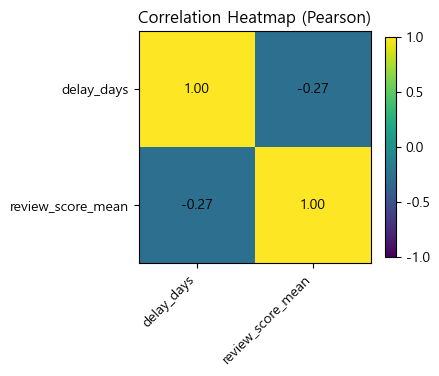

In [ ]:
# 배송 지연 정도와 점수의 선형 관계 확인
from scipy.stats import pearsonr, spearmanr

# 1) 분석용 데이터 정리
order_cols = [
    "order_id",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_score_mean",
]
dfm = (
    merge_oicsr[order_cols]
    .drop_duplicates(subset=["order_id"])
    .copy()
)

# delay_days 계산: (실제 수령일 - 예상 수령일) [일]
dfm["delay_days"] = (
    dfm["order_delivered_customer_date"].dt.floor("D")
    - dfm["order_estimated_delivery_date"].dt.floor("D")
).dt.days

# 상관분석 대상만 남기기
dfc = dfm[["delay_days", "review_score_mean"]].dropna()

# 2) 상관계수 계산 (피어슨/스피어만)
pearson_r, pearson_p = pearsonr(dfc["delay_days"], dfc["review_score_mean"])
spearman_r, spearman_p = spearmanr(dfc["delay_days"], dfc["review_score_mean"])

print("=== 상관분석 결과 (주문 단위) ===")
print(f"Pearson r = {pearson_r:.4f}, p-value = {pearson_p:.4g}")
print(f"Spearman r = {spearman_r:.4f}, p-value = {spearman_p:.4g}")

# 3) 상관행렬(히트맵용)
corr_mat = dfc.corr(method="pearson")  # 필요시 'spearman'으로 변경 가능
print("\n상관행렬 (Pearson):")
print(corr_mat)

# 4) 히트맵 시각화 (matplotlib만 사용)
fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(corr_mat.values, vmin=-1, vmax=1)
ax.set_xticks(range(corr_mat.shape[1]))
ax.set_yticks(range(corr_mat.shape[0]))
ax.set_xticklabels(corr_mat.columns, rotation=45, ha="right")
ax.set_yticklabels(corr_mat.index)
ax.set_title("Correlation Heatmap (Pearson)")
# 셀 값 주석
for (i, j), val in np.ndenumerate(corr_mat.values):
    ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()


=== 주별 delay_days ↔ review_score_mean 상관관계 ===
   customer_state  pearson_r        p_value  n_orders
5              CE  -0.467834   9.750453e-70      1264
1              AL  -0.460527   7.192713e-22       390
13             PA  -0.416755   1.855193e-40       932
18             RJ  -0.404840   0.000000e+00     12147
19             RN  -0.402377   1.216897e-19       468
15             PE  -0.396816   1.794693e-60      1573
24             SE  -0.394887   7.138221e-14       333
0              AC  -0.379634   5.144924e-04        80
11             MS  -0.373522   1.820947e-24       696
9              MA  -0.367361   3.871987e-24       711
14             PB  -0.334910   8.318875e-15       509
16             PI  -0.323645   6.743246e-13       469
23             SC  -0.319631   4.696521e-84      3504
7              ES  -0.296909   3.837962e-41      1958
8              GO  -0.293489   9.572130e-40      1935
4              BA  -0.292980   1.213868e-64      3214
26             TO  -0.286692   1.52

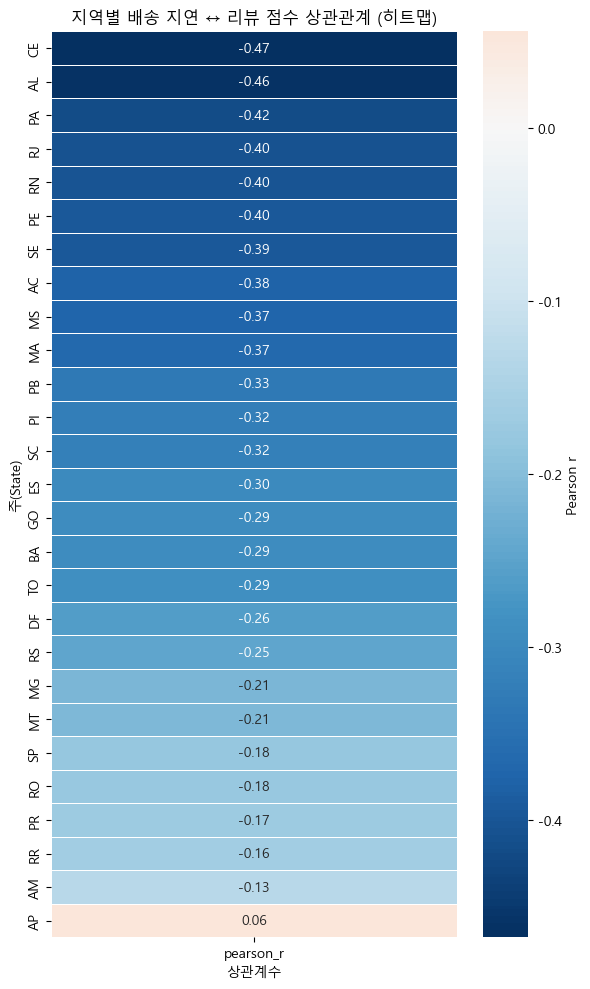

In [ ]:
# 지역별 배송-리뷰 상관관계 분석

import pandas as pd
from scipy.stats import pearsonr

# 1) 주문 단위 데이터 준비
order_cols = [
    "order_id",
    "customer_state",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "review_score_mean"
]
dfm = merge_oicsr[order_cols].drop_duplicates(subset=["order_id"]).copy()

# delay_days 계산
dfm["delay_days"] = (
    dfm["order_delivered_customer_date"].dt.floor("D")
    - dfm["order_estimated_delivery_date"].dt.floor("D")
).dt.days

# 필요한 컬럼만
dfc = dfm[["customer_state", "delay_days", "review_score_mean"]].dropna()

# 2) 주(state)별 상관계수 계산
state_corrs = []
for state, group in dfc.groupby("customer_state"):
    if len(group) > 5:  # 샘플이 너무 적은 주는 제외
        r, p = pearsonr(group["delay_days"], group["review_score_mean"])
        state_corrs.append({"customer_state": state, "pearson_r": r, "p_value": p, "n_orders": len(group)})

state_corrs_df = pd.DataFrame(state_corrs).sort_values("pearson_r")

# 3) 결과 확인
print("=== 주별 delay_days ↔ review_score_mean 상관관계 ===")
print(state_corrs_df)

# 4) 시각화
# 피벗테이블 형태로 바꾸기 (state × pearson_r)
heatmap_data = state_corrs_df.set_index("customer_state")[["pearson_r"]]

# 히트맵 그리기
plt.figure(figsize=(6,10))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".2f", cmap="RdBu_r", center=0,
    linewidths=0.5, cbar_kws={'label': 'Pearson r'}
)
plt.title("지역별 배송 지연 ↔ 리뷰 점수 상관관계 (히트맵)")
plt.ylabel("주(State)")
plt.xlabel("상관계수")
plt.tight_layout()
plt.show()
